<a href="https://www.kaggle.com/code/yasinsoylu123/dogecoin-time-series-and-lstm?scriptVersionId=116419991" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogecoin-historical-dataset-2014-to-2021/DOGE-USD.csv


In [22]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Plotting
%matplotlib inline
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,10) #Make the plots bigger by default
plt.rcParams["lines.linewidth"] = 2 #Setting the default line width
plt.style.use("ggplot")

from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping , ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error

import warnings
import warnings
warnings.filterwarnings('ignore')

In [23]:
df = pd.read_csv("/kaggle/input/dogecoin-historical-dataset-2014-to-2021/DOGE-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0
1,2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0
2,2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0
3,2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0
4,2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0


In [24]:
df.isnull().sum()


Date         0
Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64

In [25]:
df["Date"]=pd.to_datetime(df.Date,dayfirst=True)
df.set_index("Date",inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1.463600e+06
2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2.215910e+06
2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,8.835630e+05
2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,9.930040e+05
2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,5.391400e+05
...,...,...,...,...,...,...
2021-10-16,0.233881,0.244447,0.233683,0.237292,0.237292,1.541851e+09
2021-10-17,0.237193,0.241973,0.226380,0.237898,0.237898,1.397143e+09
2021-10-18,0.237806,0.271394,0.237488,0.247281,0.247281,5.003366e+09


In [26]:
df=df.asfreq("d")
df = df.fillna(method  = "bfill")

Text(0, 0.5, 'open price')

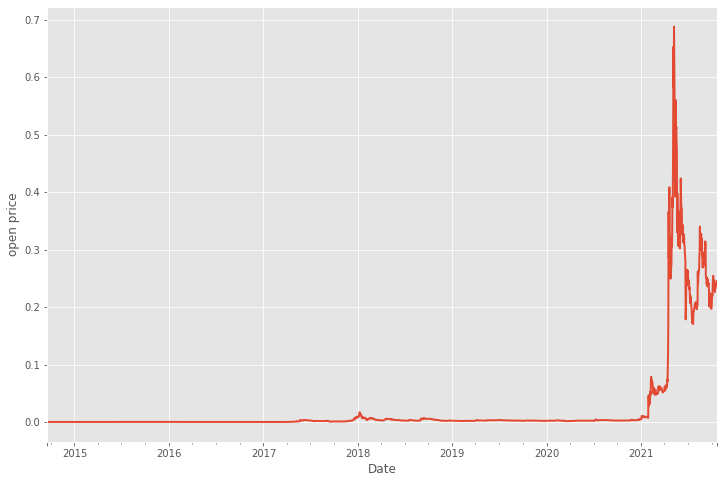

In [27]:
df['Open'].plot(figsize=(12,8))
plt.ylabel("open price")

Text(0, 0.5, 'Volume price')

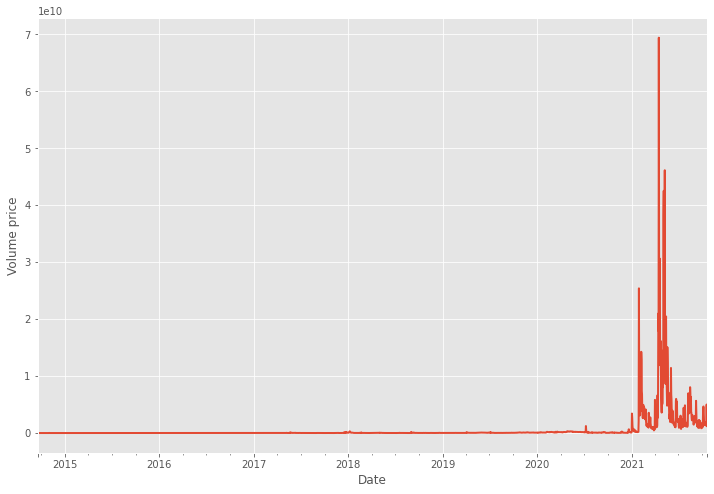

In [28]:
df['Volume'].plot(figsize=(12,8))
plt.ylabel("Volume price")

In [29]:
df['Total Pos'] = df.sum(axis=1)


Text(0.5, 1.0, 'Total Portfolio Value')

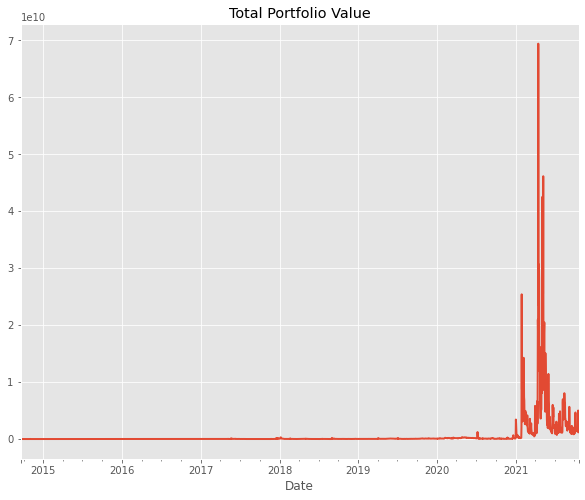

In [30]:
df['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

In [31]:
df['Daily Return'] = df['Total Pos'].pct_change(1)


In [32]:
df['Daily Return'].mean()


0.18606747432306844

<AxesSubplot:ylabel='Density'>

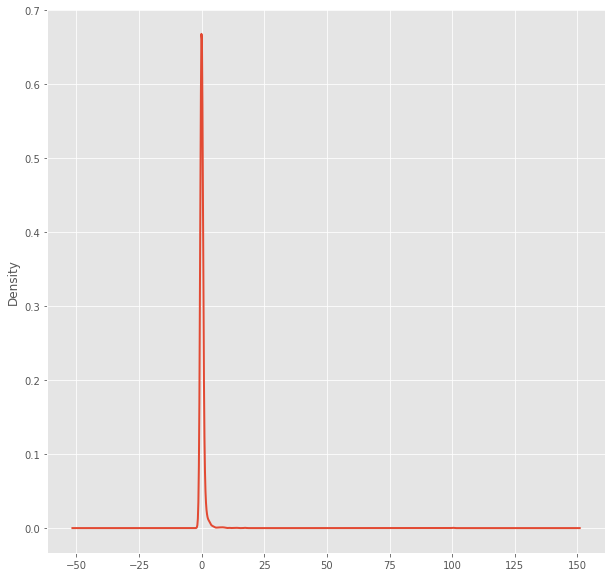

In [33]:
df['Daily Return'].plot(kind='kde')


In [34]:
SR = df['Daily Return'].mean()/df['Daily Return'].std()


<AxesSubplot:xlabel='Date'>

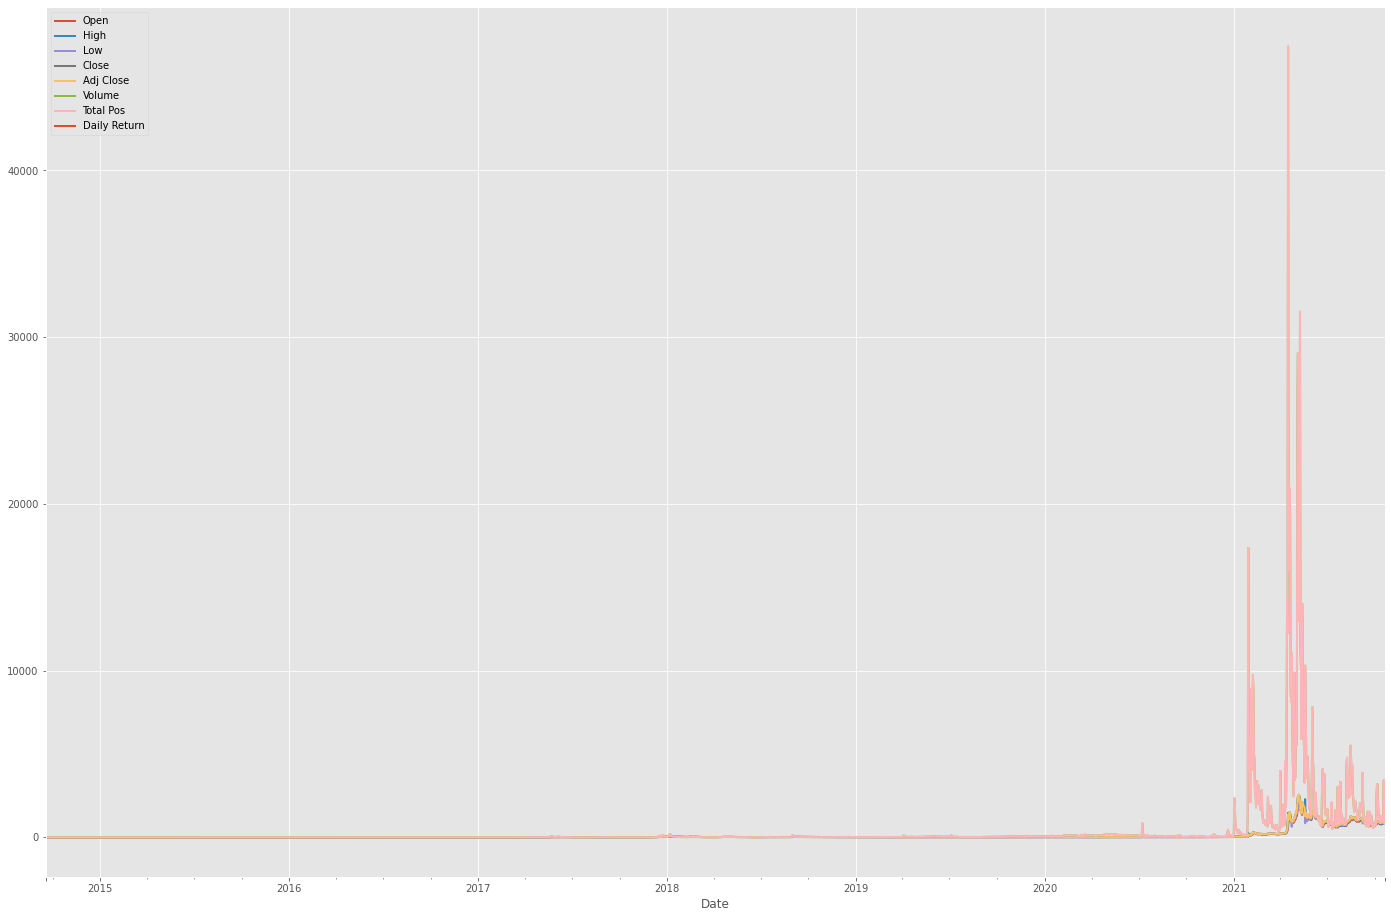

In [35]:
all_plot = df/df.iloc[0]
all_plot.plot(figsize=(24,16))

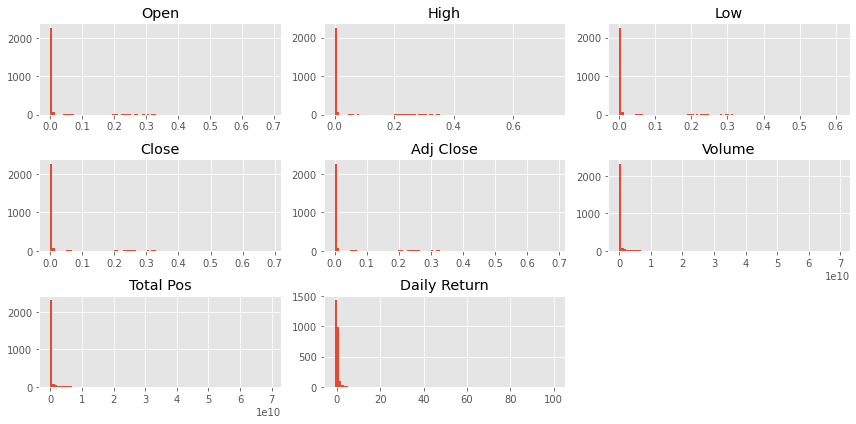

In [36]:
df.hist(bins=100,figsize=(12,6));
plt.tight_layout()

In [37]:
df.resample(rule='A').mean()


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return
Date,,,,,,,,
2014-12-31,0.000249,0.000259,0.000240,0.000248,0.000248,8.059213e+05,8.059213e+05,1.028630
2015-12-31,0.000143,0.000147,0.000139,0.000143,0.000143,1.685476e+05,1.685476e+05,0.139461
2016-12-31,0.000235,0.000242,0.000229,0.000235,0.000235,2.564834e+05,2.564834e+05,0.259038
2017-12-31,0.001576,0.001708,0.001468,0.001601,0.001601,1.118996e+07,1.118996e+07,0.225833
2018-12-31,0.004368,0.004577,0.004125,0.004350,0.004350,2.172325e+07,2.172325e+07,0.109586
2019-12-31,0.002564,0.002631,0.002499,0.002563,0.002563,4.463969e+07,4.463969e+07,0.027981
2020-12-31,0.002736,0.002822,0.002660,0.002744,0.002744,1.290465e+08,1.290465e+08,0.052314
2021-12-31,0.200410,0.215775,0.185770,0.201272,0.201272,4.620961e+09,4.620961e+09,0.260782


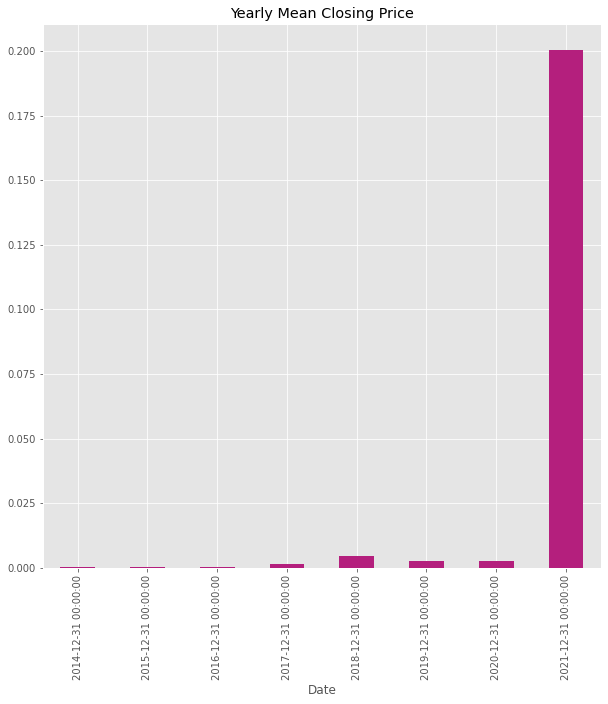

In [38]:
title = 'Yearly Mean Closing Price'
df['Open'].resample('A').mean().plot.bar(title=title,color=['#b41f7d']);

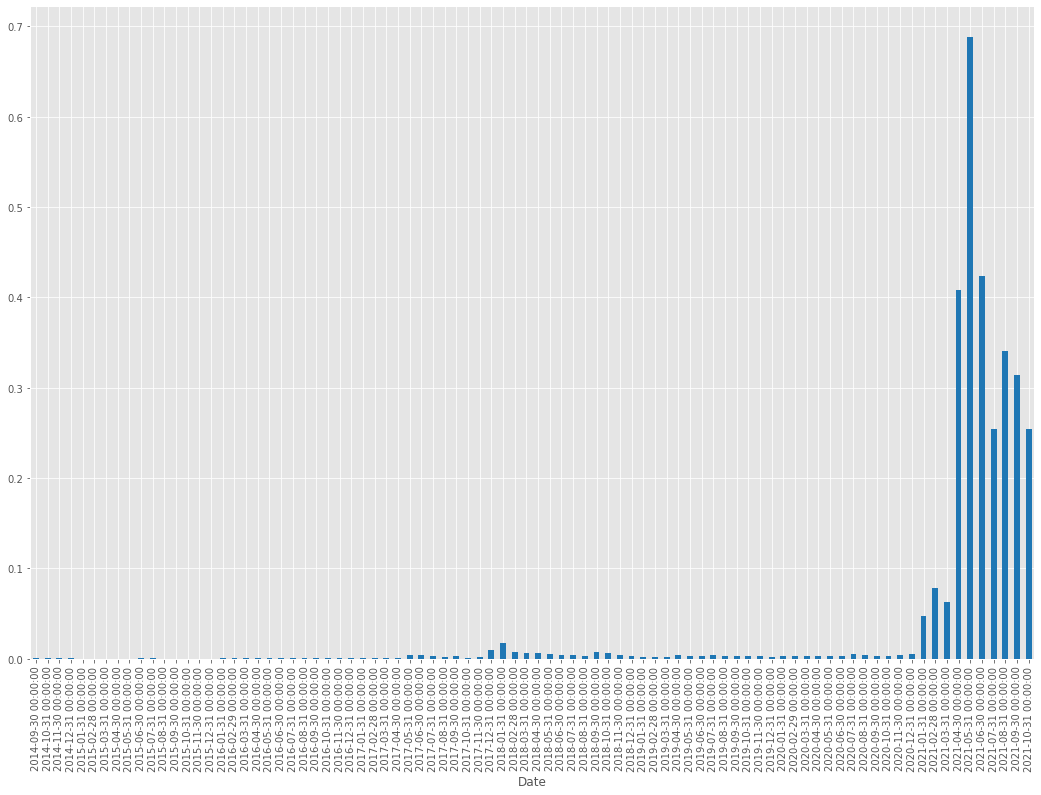

In [39]:
df['Open'].resample('M').max().plot.bar(figsize=(18,12),color='#1f77b4');


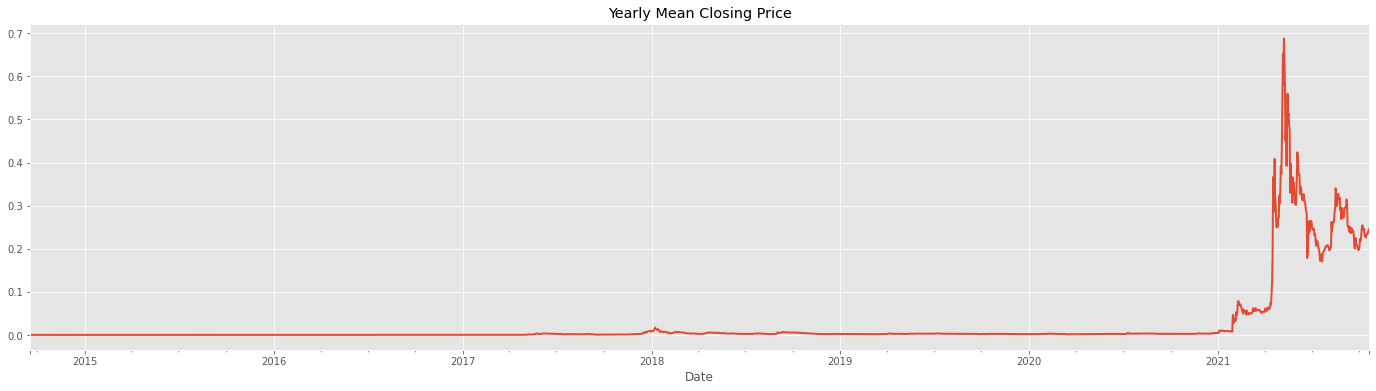

In [40]:
ax = df['Open'].plot(figsize=(24,6),title=title)


In [41]:
df['6-month-SMA'] = df['Open'].rolling(window=6).mean()
df['12-month-SMA'] = df['Open'].rolling(window=12).mean()
df['2-month-SMA'] = df['Open'].rolling(window=2).mean()

In [42]:
df.head(13)


,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA
Date,,,,,,,,,,,
2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0,1.463600e+06,NaN,NaN,NaN,NaN
2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0,2.215910e+06,0.514013,NaN,NaN,0.000281
2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0,8.835630e+05,-0.601264,NaN,NaN,0.000283
2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0,9.930040e+05,0.123863,NaN,NaN,0.000287
2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0,5.391400e+05,-0.457062,NaN,NaN,0.000285
2014-09-22,0.000288,0.000301,0.000285,0.000298,0.000298,620222.0,6.202220e+05,0.150391,0.000286,NaN,0.000291
2014-09-23,0.000298,0.000318,0.000295,0.000313,0.000313,739197.0,7.391970e+05,0.191826,0.000287,NaN,0.000293
2014-09-24,0.000314,0.000353,0.000310,0.000348,0.000348,1277840.0,1.277840e+06,0.728687,0.000295,NaN,0.000306
2014-09-25,0.000347,0.000383,0.000332,0.000375,0.000375,2393610.0,2.393610e+06,0.873169,0.000303,NaN,0.000330


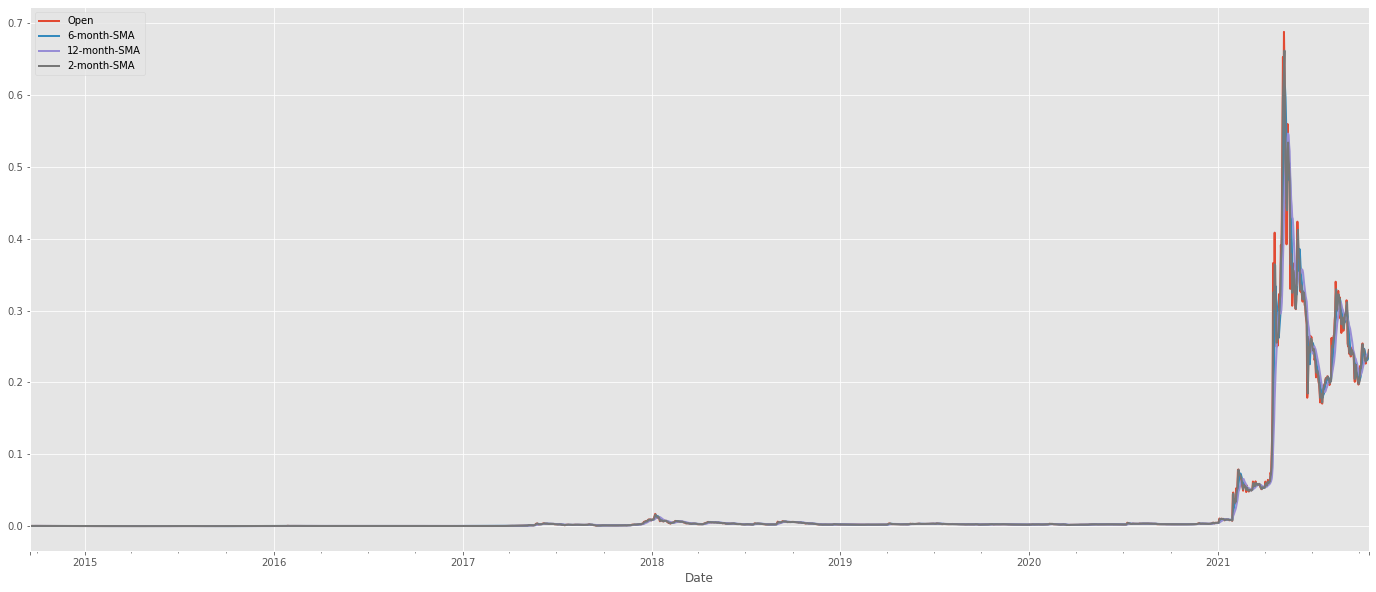

In [43]:
df[["Open","6-month-SMA","12-month-SMA","2-month-SMA"]].plot(figsize=(24,10));


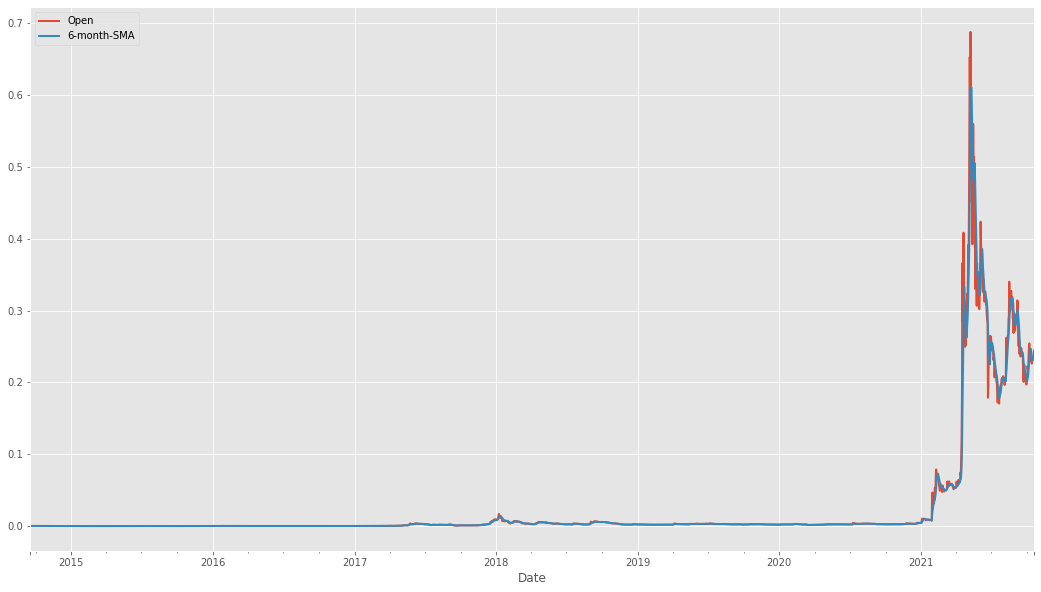

In [44]:
df[["Open","6-month-SMA"]].plot(figsize=(18,10));


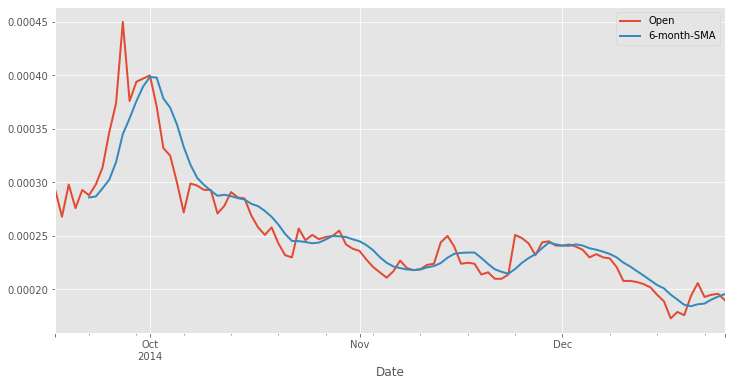

In [45]:
df[['Open','6-month-SMA']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [46]:
df['EWMA12'] = df['Open'].ewm(span=14,adjust=True).mean()


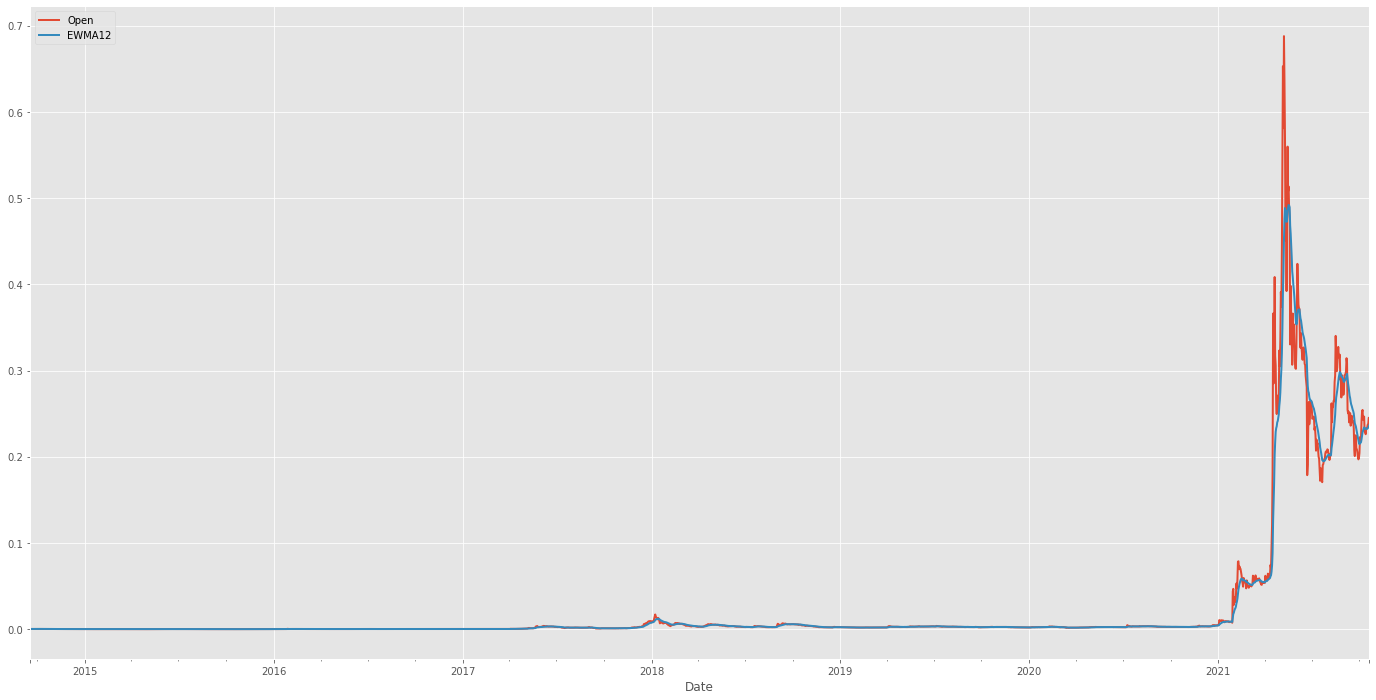

In [47]:
df[['Open','EWMA12']].plot(figsize=(24,12));


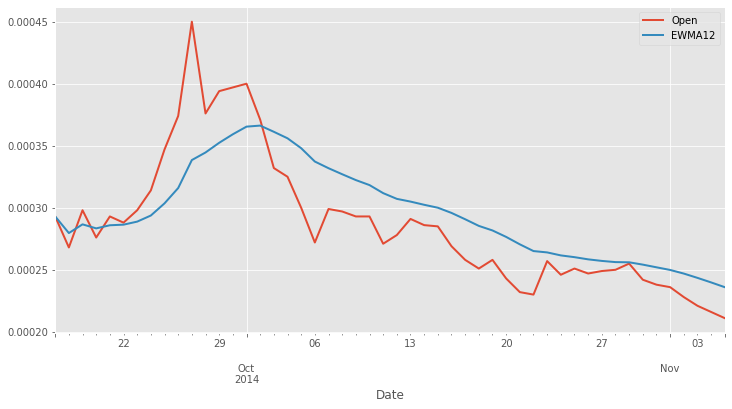

In [48]:
df[['Open','EWMA12']].iloc[:50].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [49]:
df['EWMA12'] = df['Open'].ewm(span=14,adjust=True).mean()


In [50]:
span = 8
alpha = 2/(span+1)

In [51]:
df['EWMA12'] = df['Open'].ewm(alpha=alpha,adjust=False).mean()


In [52]:
model=SimpleExpSmoothing(df["Open"])


In [53]:
model.fit(smoothing_level=alpha,optimized=False)


In [54]:
fitted_model=model.fit(smoothing_level=alpha,optimized=False)


In [55]:
fitted_model.fittedvalues


Date
2014-09-17    0.000293
2014-09-18    0.000293
2014-09-19    0.000287
2014-09-20    0.000290
2014-09-21    0.000287
                ...   
2021-10-16    0.233280
2021-10-17    0.233414
2021-10-18    0.234254
2021-10-19    0.235043
2021-10-20    0.237300
Freq: D, Length: 2591, dtype: float64

In [56]:
fitted_model.fittedvalues.shift(-1)


Date
2014-09-17    0.000293
2014-09-18    0.000287
2014-09-19    0.000290
2014-09-20    0.000287
2014-09-21    0.000288
                ...   
2021-10-16    0.233414
2021-10-17    0.234254
2021-10-18    0.235043
2021-10-19    0.237300
2021-10-20         NaN
Freq: D, Length: 2591, dtype: float64

In [57]:
df["SES12"]=fitted_model.fittedvalues.shift(-1)


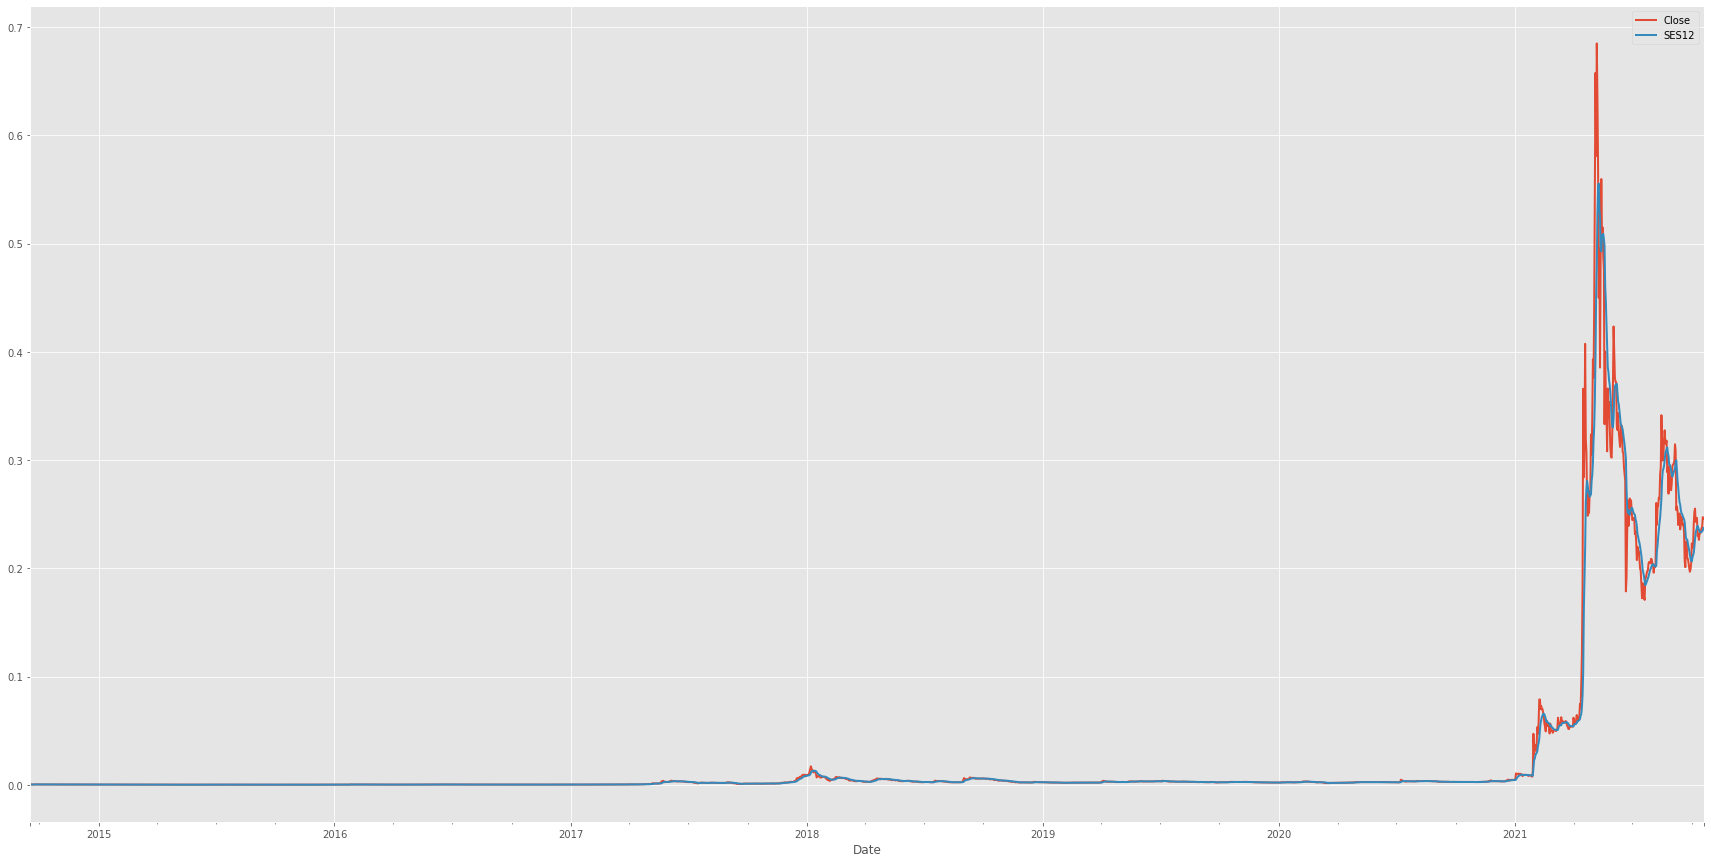

In [58]:
df[['Close',"SES12"]].plot(figsize=(30,15)).autoscale(axis='x',tight=True);


In [59]:
df['DESadd12'] = ExponentialSmoothing(df['Open'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12
Date,,,,,,,,,,,,,,
2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0,1.463600e+06,NaN,NaN,NaN,NaN,0.000293,0.000293,0.000378
2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0,2.215910e+06,0.514013,NaN,NaN,0.000281,0.000287,0.000287,0.000379
2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0,8.835630e+05,-0.601264,NaN,NaN,0.000283,0.000290,0.000290,0.000406
2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0,9.930040e+05,0.123863,NaN,NaN,0.000287,0.000287,0.000287,0.000389
2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0,5.391400e+05,-0.457062,NaN,NaN,0.000285,0.000288,0.000288,0.000403


<AxesSubplot:xlabel='Date'>

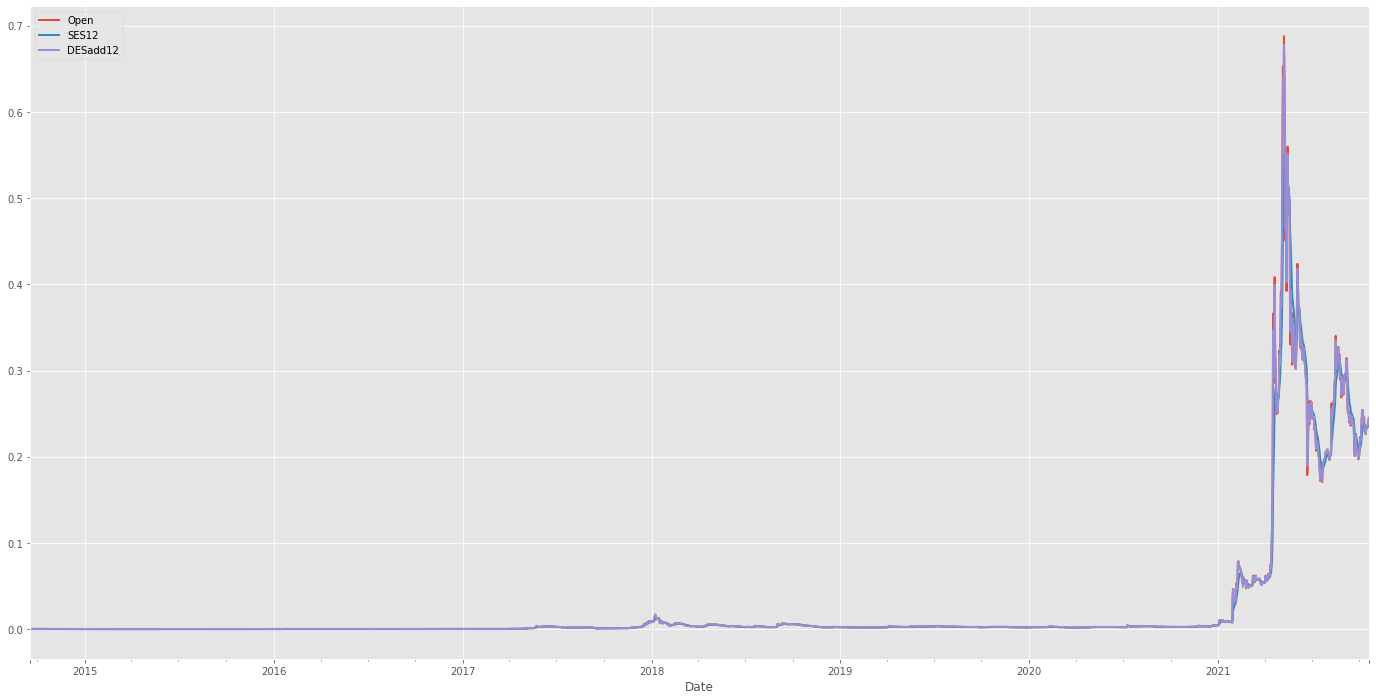

In [60]:
df[['Open',  'SES12', 'DESadd12']].plot(figsize=(24,12))


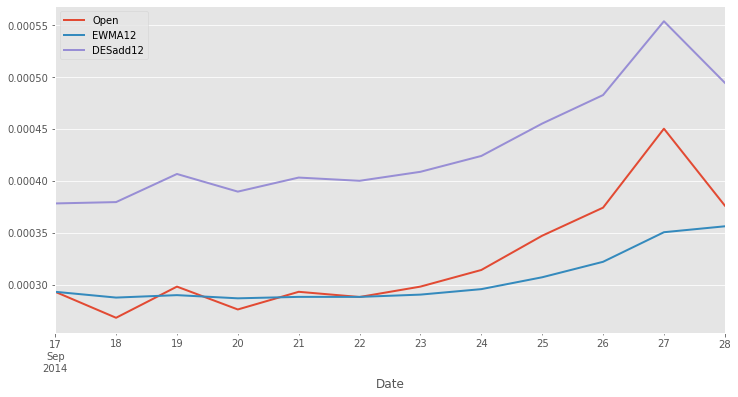

In [61]:
df[['Open','EWMA12','DESadd12']].iloc[:12].plot(figsize=(12,6)).autoscale(axis='x',tight=True);


In [62]:
df['DESmul12'] = ExponentialSmoothing(df['Open'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12
Date,,,,,,,,,,,,,,,
2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0,1.463600e+06,NaN,NaN,NaN,NaN,0.000293,0.000293,0.000378,NaN
2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0,2.215910e+06,0.514013,NaN,NaN,0.000281,0.000287,0.000287,0.000379,NaN
2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0,8.835630e+05,-0.601264,NaN,NaN,0.000283,0.000290,0.000290,0.000406,NaN
2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0,9.930040e+05,0.123863,NaN,NaN,0.000287,0.000287,0.000287,0.000389,NaN
2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0,5.391400e+05,-0.457062,NaN,NaN,0.000285,0.000288,0.000288,0.000403,NaN


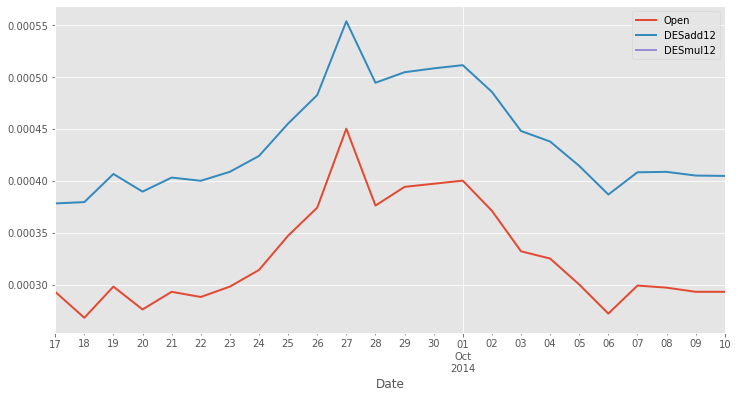

In [63]:
df[['Open','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [64]:
df['TESadd12'] = ExponentialSmoothing(df['Open'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Date,,,,,,,,,,,,,,,,
2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0,1.463600e+06,NaN,NaN,NaN,NaN,0.000293,0.000293,0.000378,NaN,0.000243
2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0,2.215910e+06,0.514013,NaN,NaN,0.000281,0.000287,0.000287,0.000379,NaN,0.000478
2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0,8.835630e+05,-0.601264,NaN,NaN,0.000283,0.000290,0.000290,0.000406,NaN,0.000500
2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0,9.930040e+05,0.123863,NaN,NaN,0.000287,0.000287,0.000287,0.000389,NaN,0.000350
2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0,5.391400e+05,-0.457062,NaN,NaN,0.000285,0.000288,0.000288,0.000403,NaN,0.000586


In [65]:
df['TESmul12'] = ExponentialSmoothing(df['Open'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Open,High,Low,Close,Adj Close,Volume,Total Pos,Daily Return,6-month-SMA,12-month-SMA,2-month-SMA,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Date,,,,,,,,,,,,,,,,,
2014-09-17,0.000293,0.000299,0.000260,0.000268,0.000268,1463600.0,1.463600e+06,NaN,NaN,NaN,NaN,0.000293,0.000293,0.000378,NaN,0.000243,NaN
2014-09-18,0.000268,0.000325,0.000267,0.000298,0.000298,2215910.0,2.215910e+06,0.514013,NaN,NaN,0.000281,0.000287,0.000287,0.000379,NaN,0.000478,NaN
2014-09-19,0.000298,0.000307,0.000275,0.000277,0.000277,883563.0,8.835630e+05,-0.601264,NaN,NaN,0.000283,0.000290,0.000290,0.000406,NaN,0.000500,NaN
2014-09-20,0.000276,0.000310,0.000267,0.000292,0.000292,993004.0,9.930040e+05,0.123863,NaN,NaN,0.000287,0.000287,0.000287,0.000389,NaN,0.000350,NaN
2014-09-21,0.000293,0.000299,0.000284,0.000288,0.000288,539140.0,5.391400e+05,-0.457062,NaN,NaN,0.000285,0.000288,0.000288,0.000403,NaN,0.000586,NaN


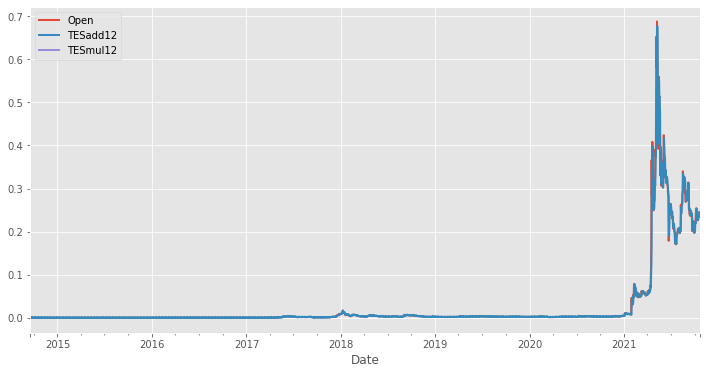

In [66]:
df[['Open','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

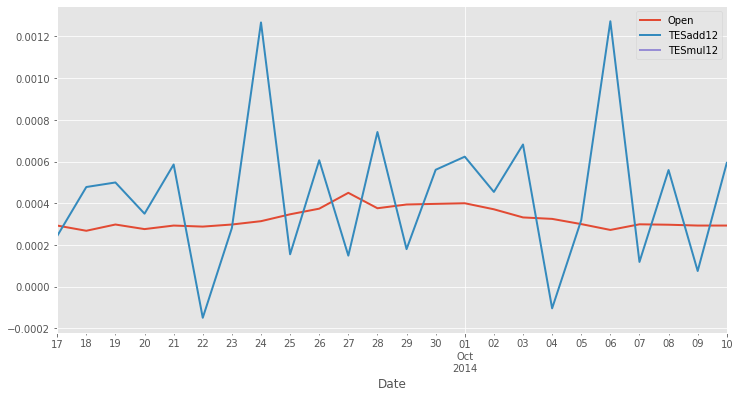

In [67]:
df[['Open','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

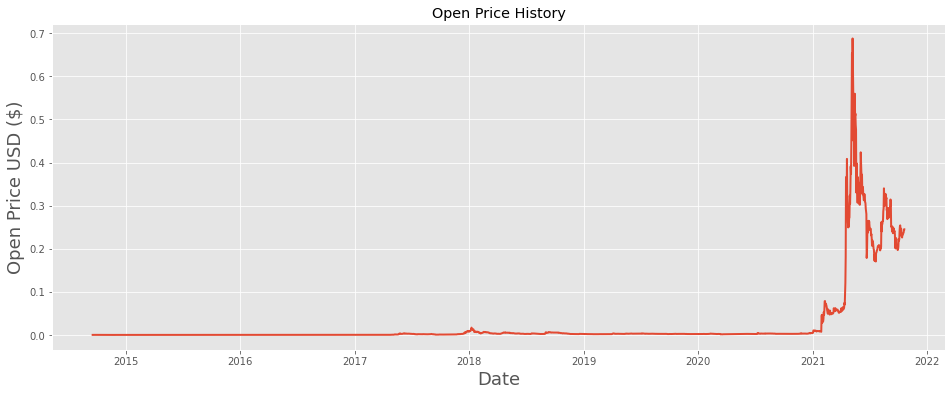

In [68]:
plt.figure(figsize=(16,6))
plt.title('Open Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.show()

# LSTM MODEL¶


In [69]:
data = df.filter(['Open'])

dataset = data.values

training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2462

In [70]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[2.99543124e-04],
       [2.63190803e-04],
       [3.06813588e-04],
       ...,
       [3.45665495e-01],
       [3.56415603e-01],
       [3.56415603e-01]])

In [71]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        

x_train, y_train = np.array(x_train), np.array(y_train)


x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.00029954, 0.00026319, 0.00030681, 0.00027482, 0.00029954,
       0.00029227, 0.00030681, 0.00033008, 0.00037806, 0.00041732,
       0.00052784, 0.00042023, 0.00044641, 0.00045077, 0.00045513,
       0.00041296, 0.00035625, 0.00034607, 0.00030972, 0.00026901,
       0.00030827, 0.00030536, 0.00029954, 0.00029954, 0.00026755,
       0.00027773, 0.00029663, 0.00028936, 0.00028791, 0.00026464,
       0.00024865, 0.00023847, 0.00024865, 0.00022684, 0.00021084,
       0.00020794, 0.0002472 , 0.0002312 , 0.00023847, 0.00023265,
       0.00023556, 0.00023702, 0.00024429, 0.00022538, 0.00021957,
       0.00021666, 0.00020503, 0.00019485, 0.00018758, 0.00018031,
       0.00018903, 0.00020357, 0.00019339, 0.00019049, 0.00019194,
       0.00019776, 0.00019921, 0.00022829, 0.00023702, 0.00022248])]
[0.0001992107184091061]

[array([0.00029954, 0.00026319, 0.00030681, 0.00027482, 0.00029954,
       0.00029227, 0.00030681, 0.00033008, 0.00037806, 0.00041732,
       0.00052784, 0.00042023, 0.

In [72]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

In [73]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [74]:
import time
tic = time.clock()
toc = time.clock()
toc - tic

callbacks = [EarlyStopping(patience=3, monitor='val_loss', mode='min'), 
             ReduceLROnPlateau(patience=2, verbose=1)]  

In [75]:
history =model.fit(x_train, y_train, 
                        epochs=2,
                        batch_size=1,
                        callbacks=[callbacks],
                        )

Epoch 1/2
2402/2402 [==============================] - 15s 5ms/step - loss: 0.0022
Epoch 2/2
2402/2402 [==============================] - 13s 5ms/step - loss: 7.3283e-04


In [76]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

In [77]:
mean_absolute_error(y_test, predictions)

0.030666244135723553

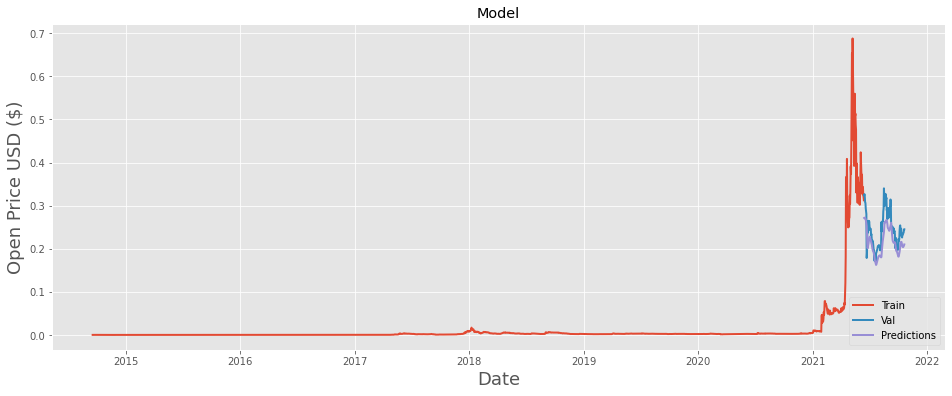

In [78]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [79]:
predictions = model.predict(x_test)

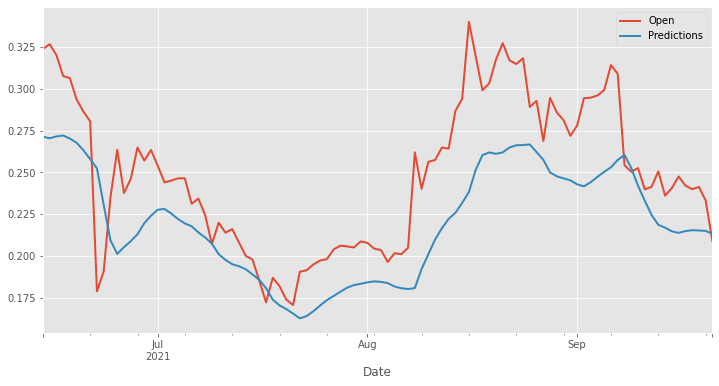

In [80]:
valid[['Open','Predictions']].iloc[:100].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [81]:
valid


,Open,Predictions
Date,,
2021-06-14,0.323903,0.271375
2021-06-15,0.326785,0.270426
2021-06-16,0.320378,0.271516
2021-06-17,0.307749,0.272099
2021-06-18,0.306428,0.270246
...,...,...
2021-10-16,0.233881,0.203847
2021-10-17,0.237193,0.204419
2021-10-18,0.237806,0.205867
